# Libraries

In [1]:
import sys
sys.executable

'/home/avgupta/anaconda2/bin/python2'

In [2]:
#import snap
import collections
from collections import namedtuple
import numpy as np
import pdb
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance
import copy
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
np.random.seed(3)

# Defining the Ratings Graph Class

In [4]:
Rating = namedtuple('Rating', ['Rating', 'User', 'Object'])

def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

def get_data_set():
    movie_critic_ratings = {}
    
    movie_header_indeces = {}
    for line in open('data/grouplens/movies.dat'):
        line = line.strip()
        if not movie_header_indeces:
            for i, column in enumerate(line.split('\t')):
                movie_header_indeces[column] = i
            continue
        NUM_TOP_CRITICS_REVIEWS_IDX = movie_header_indeces['rtTopCriticsNumReviews']
        TOP_CRITICS_RATING_IDX = movie_header_indeces['rtTopCriticsRating']
        
        movie_id, critic_rating, num_critic_ratings = line.split()[0], line.split()[TOP_CRITICS_RATING_IDX], line.split()[NUM_TOP_CRITICS_REVIEWS_IDX]
        
        if isfloat(num_critic_ratings) and (num_critic_ratings > 10) and isfloat(critic_rating):
            critic_rating = float(critic_rating) / 10.0
            movie_critic_ratings[movie_id] = critic_rating
        
    user_rating_header_indeces = {}
    ratings = []
    for line in open('data/grouplens/user_ratedmovies.dat'):
        line = line.strip()
        if not user_rating_header_indeces:
            for i, column in enumerate(line.split('\t')):
                user_rating_header_indeces[column] = i
            continue
        
        user_id, movie_id, rating = line.split()[0], line.split()[1], line.split()[2]
        rating = float(rating) / 5.0
        ratings.append(Rating(Rating=rating, User=user_id, Object=movie_id))
    
    movie_genres = collections.defaultdict(list)
    genre_counter = 0
    genre_lookup = {}
    for line in open('data/grouplens/movie_genres.dat'):
        line = line.strip()
        movie_id, genre = line.split()
        if genre not in genre_lookup.keys():
            genre_lookup[genre] = genre_counter
            genre_counter += 1
        movie_genres[movie_id] += [genre_lookup[genre]]
    return ratings, movie_critic_ratings, movie_genres

ratings, movie_critic_ratings, movie_genres = get_data_set()

In [5]:
movie_genres['2']

[1, 3, 5]

In [16]:
Rating = namedtuple('Rating', ['Rating', 'User', 'Object'])

class RatingsGraph:
    def __init__(self, ratings, gold_ratings, movie_genres, alpha):
        self.alpha = alpha
        self.ratings = ratings 
        self.gold_ratings_dict = gold_ratings #(object, gold_rating)
        
        user_set = set([rating.User for rating in self.ratings]) 
        users_lookup = {user: i for i, user in enumerate(user_set)}
        object_set = set([rating.Object for rating in self.ratings])
        objects_lookup = {obj: i for i, obj in enumerate(object_set)}
        
        num_users, num_objects = len(user_set), len(object_set)
        self.bias_diffs = []
        
        # create adjacency matrix from ratings
        self.adjacency = np.zeros([num_users, num_objects]) - 1 #set them to -1 bc rating can be 0
        for rating in self.ratings:
            idx_user = users_lookup[rating.User]
            idx_obj = objects_lookup[rating.Object]
            self.adjacency[idx_user, idx_obj] = rating.Rating
        
        # create genres vectors and similarity matrix
        num_genres = max([genre for movie, genre_list in movie_genres.iteritems() for genre in genre_list]) + 1
        genre_vectors = np.zeros((num_objects, num_genres))
        for movie, idx in objects_lookup.iteritems():
            for genre in movie_genres[movie]:
                genre_vectors[idx, genre] = 1
        self.similarity = 1-distance.cdist(genre_vectors, genre_vectors, 'euclidean')
        # precalculate sum of similarities over movies for each user
        self.user_sum_similarity = np.expand_dims(1.0/np.sum((self.adjacency >= 0).dot(self.similarity),1), axis=1)

        self.true_ratings = np.random.uniform(low = 0, high = 1, size = (num_objects, 1))
        self.biases = np.random.uniform(low = -1, high = 1, size = (num_users, num_objects))
        
        self.gold_ratings = np.zeros([num_objects, 1]) - 1
        for obj, gold_rating in self.gold_ratings_dict.iteritems():
            try:
                obj_idx = objects_lookup[obj]
                self.gold_ratings[obj_idx] = gold_rating
            except: continue
    
    def perform_single_iteration(self):
        converged = True
        alpha = self.alpha
        
        original_ratings = self.true_ratings.copy()
        # subtract user biases from all ratings, but only where rating existed in first place!
        updated_ratings = np.multiply((self.adjacency >= 0), self.adjacency - alpha*self.biases)
        self.true_ratings = (1.0/np.sum(self.adjacency >= 0, axis = 0))* \
            np.sum(np.maximum(np.zeros(self.adjacency.shape),
                       np.minimum(np.ones(self.adjacency.shape), updated_ratings))
            , axis = 0)
            
        max_diff = np.max(np.absolute(original_ratings - np.expand_dims(self.true_ratings,1)))
        if max_diff > 0.00001:  
            converged = False
            
        original_bias = self.biases.copy()
        # subtract true ratings from given ratings - only where a rating was originally given!
        self.biases = self.user_sum_similarity * \
            (np.multiply((self.adjacency >= 0), self.adjacency - self.true_ratings)).dot(self.similarity)
                 
        bias_diff = np.absolute(original_bias - self.biases)
        if np.max(bias_diff) > 0.00001:
            converged = False
        self.bias_diffs.append(np.sum(bias_diff))
        #print "Bias Diff: {}".format(np.sum(bias_diff))        
        
        self.true_ratings = np.expand_dims(self.true_ratings, axis=1) # to make the shapes work
        
        return converged
    
    def get_test_error(self):
        num_gold_ratings = np.sum(self.gold_ratings >= 0)
        pred_ratings = (self.gold_ratings >= 0)*self.true_ratings # if not in gold ratings, set to 0
        gold_ratings_given = (self.gold_ratings >= 0) * self.gold_ratings
        return 1.0/num_gold_ratings * np.sum(np.square(pred_ratings - gold_ratings_given))
            
    def iterate_until_convergence(self):
        errors = []
        converged = False
        counter = 0
        max_iter = 100
        while not converged and counter < max_iter:
            error = self.get_test_error()
            print (error)
            errors.append(error)
            converged = self.perform_single_iteration()
            counter += 1
        return errors

In [18]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, movie_genres, alpha=0.1)
errors = ratings_graph.iterate_until_convergence()
alpha_01_y = ratings_graph.bias_diffs

62.11946220488271
61.4955053225551
61.49332499742239


In [19]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, movie_genres, alpha=0.2)
errors = ratings_graph.iterate_until_convergence()
alpha_02_y = ratings_graph.bias_diffs

62.100019134203976
61.505377430849144
61.49332517351349


In [20]:
ratings_graph = RatingsGraph(ratings, movie_critic_ratings, movie_genres, alpha=0.5)
errors = ratings_graph.iterate_until_convergence()
alpha_05_y = ratings_graph.bias_diffs

62.16316292698287
61.5854831619719
61.493329949096065


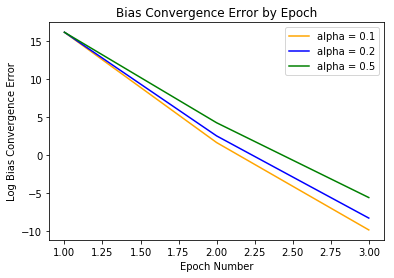

In [21]:
plt.plot([i+1 for i in range(len(alpha_01_y))], [np.log(y) for y in alpha_01_y], 'orange', label='alpha = 0.1')
plt.plot([i+1 for i in range(len(alpha_02_y))], [np.log(y) for y in alpha_02_y], '-b', label='alpha = 0.2')
plt.plot([i+1 for i in range(len(alpha_05_y))], [np.log(y) for y in alpha_05_y], '-g', label='alpha = 0.5')
plt.legend()
plt.title('Bias Convergence Error by Epoch')
plt.xlabel('Epoch Number')
plt.ylabel('Log Bias Convergence Error')